Standard Scale -> test 제외 후 각각

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
import pandas as pd

raw_train = pd.read_csv("/content/drive/MyDrive/adj_raw_train.csv")

In [ ]:
#date열 str에서 datetime형으로 변환
raw_train['date'] = pd.to_datetime(raw_train['date'])

In [ ]:
target_year=2021
train = raw_train[raw_train['date'].dt.year<target_year]
len(train)

981

In [ ]:
target_year=2021
validation = raw_train[raw_train['date'].dt.year==target_year]
len(validation)

248

In [ ]:
target_year=2022
test = raw_train[raw_train['date'].dt.year==target_year]
len(test)

246

In [ ]:
raw_train

date    close     open     high      low        rsi  MACD_12_26  \
0     2017-01-02  2026.16  2022.23  2031.79  2015.68  51.846817    1.534583   
1     2017-01-03  2043.97  2034.31  2044.07  2028.47  51.846817    1.534583   
2     2017-01-04  2045.64  2046.29  2046.29  2040.61  51.846817    1.534583   
3     2017-01-05  2041.95  2045.52  2046.50  2039.49  51.846817    1.534583   
4     2017-01-06  2049.12  2048.11  2051.84  2045.66  51.846817    1.534583   
...          ...      ...      ...      ...      ...        ...         ...   
1470  2022-12-23  2313.69  2325.86  2333.08  2311.90  38.363622  -15.931807   
1471  2022-12-26  2317.14  2312.54  2321.92  2304.20  39.169097  -18.026966   
1472  2022-12-27  2332.79  2327.52  2335.99  2321.48  42.819515  -18.214604   
1473  2022-12-28  2280.45  2296.45  2296.45  2276.90  35.209547  -22.329310   
1474  2022-12-29  2236.40  2265.73  2272.67  2236.38  30.324860  -28.812578   

             mavg   CSI       kalman     target  
0     2436.844485  93.3  1013.080000 -16.745712  
1     2436.844485  93.3  1361.261391   0.879003  
2     2436.844485  93.3  1537.845936   0.081704  
3     2436.844485  93.3  1644.398399  -0.180384  
4     2436.844485  93.3  1717.753085   0.351135  
...           ...   ...          ...        ...  
1470  2386.713000  90.2  2371.007500  -1.826259  
1471  2382.156500  90.2  2365.883358   0.149112  
1472  2377.126500  90.2  2362.735355   0.675402  
1473  2367.522500  90.2  2354.907967  -2.243665  
1474  2355.350500  90.2  2343.634906  -1.931636  

[1475 rows x 11 columns]

In [ ]:
raw_train['target'] = raw_train.d_ret

In [ ]:
raw_train = raw_train.drop('d_ret',axis=1)

In [ ]:
raw_train.set_index("date",inplace=True)

# LSTM
https://pasus.tistory.com/266
https://6mini.github.io/deep%20learning/2021/10/21/NNHyperparameter/


In [221]:
raw_train.columns

Index(['close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'mavg', 'CSI',
       'kalman', 'target'],
      dtype='object')

In [218]:
# save original 'returns' prices for later
original_returns = raw_train['target'].values

# separate dates for future plotting
dates = pd.to_datetime(raw_train['date'])

In [220]:
raw_train.set_index("date",inplace=True)

In [222]:
# variables for training
cols = list(raw_train)[0:9]

# new dataframe with only training data
stock_data = raw_train[cols].astype(float)

In [224]:
stock_data.to_csv("stock_data.csv")

In [ ]:
# normalize the dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler = scaler.fit(stock_data[:1229])
stock_data_scaled = scaler.transform(stock_data[:1229])

In [ ]:
# normalize the dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

stock_data_scaled_test = scaler.transform(stock_data[1229:])

In [232]:
stock_data_target = raw_train[["target"]]

In [233]:
stock_data_target[1229:]

target
date                
2022-01-03  0.373449
2022-01-04  0.015726
2022-01-05 -1.179899
2022-01-06 -1.132036
2022-01-07  1.176499
...              ...
2022-12-23 -1.826259
2022-12-26  0.149112
2022-12-27  0.675402
2022-12-28 -2.243665
2022-12-29 -1.931636

[246 rows x 1 columns]

In [ ]:
stock_data_scaled_test.shape

(246, 9)

In [ ]:
# split to train data and test data
n_train = 981
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

n_validation = n_train + 248
val_data_scaled = stock_data_scaled[n_train: n_validation]
val_dates = dates[n_train: n_validation]

n_test = n_validation

test_data_scaled = stock_data_scaled_test
test_dates = dates[n_test:]

In [ ]:
# split to train data and test data
n_train = 981
train_data_test_scaled = stock_data_target[0: n_train]
train_dates = dates[0: n_train]

n_validation = n_train + 248
val_data_test_scaled = stock_data_target[n_train: n_validation]
val_dates = dates[n_train: n_validation]

n_test = n_validation

test_data_test_scaled = stock_data_target[n_test:]
test_dates = dates[n_test:]

In [ ]:
import numpy as np
# data reformatting for LSTM
pred_days = 1  # prediction period - 3months
seq_len = 10   # sequence length = past days for future prediction.
input_dim = 10  # input_dimension = ['close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'mavg', 'CSI', 'kalman','target]

trainX = []
trainY = []
valX = []
valY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_test_scaled[i + pred_days - 1:i + pred_days].values)

for i in range(seq_len, len(val_data_scaled)-pred_days +1):
    valX.append(val_data_scaled[i - seq_len:i, 0:val_data_scaled.shape[1]])
    valY.append(val_data_test_scaled[i + pred_days - 1:i + pred_days].values)

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_test_scaled[i + pred_days - 1:i + pred_days].values)

trainX, trainY = np.array(trainX), np.array(trainY)
valX, valY = np.array(valX), np.array(valY)
testX, testY = np.array(testX), np.array(testY)

In [ ]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)
print(valX.shape, valY.shape)

(971, 10, 9) (971, 1, 1)
(236, 10, 9) (236, 1, 1)
(238, 10, 9) (238, 1, 1)


In [ ]:
'''
(971, 10, 9) (971, 1, 1)
(236, 10, 9) (236, 1, 1)
(238, 10, 9) (238, 1, 1)
'''

In [ ]:
!pip install keras

In [ ]:
trainX.shape[2]

9

In [ ]:
# LSTM model
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]),
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

In [ ]:
# specify your learning rate
learning_rate = 0.001
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
validation_data = (valX,valY)

Epoch 1/400
243/243 [==============================] - 15s 25ms/step - loss: 1.2854 - val_loss: 0.9829
Epoch 2/400
243/243 [==============================] - 3s 13ms/step - loss: 1.2663 - val_loss: 0.9705
Epoch 3/400
243/243 [==============================] - 3s 12ms/step - loss: 1.2658 - val_loss: 1.0355
Epoch 4/400
243/243 [==============================] - 4s 16ms/step - loss: 1.2596 - val_loss: 0.9816
Epoch 5/400
243/243 [==============================] - 4s 16ms/step - loss: 1.2595 - val_loss: 0.9684
Epoch 6/400
243/243 [==============================] - 3s 13ms/step - loss: 1.2617 - val_loss: 0.9824
Epoch 7/400
243/243 [==============================] - 3s 13ms/step - loss: 1.2525 - val_loss: 0.9960
Epoch 8/400
243/243 [==============================] - 4s 16ms/step - loss: 1.2570 - val_loss: 0.9807
Epoch 9/400
243/243 [==============================] - 4s 15ms/step - loss: 1.2472 - val_loss: 0.9913
Epoch 10/400
243/243 [==============================] - 4s 15ms/step - loss: 1.24

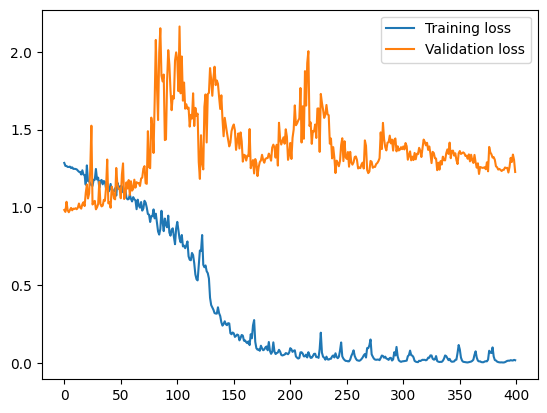

In [ ]:
# import matplotlib.pyplot as plt
try:
    model.load_weights('./lstm_weights_last.h5')
    print("Loaded model weights from disk")
except:
    # Fit the model
history = model.fit(trainX, trainY, epochs=400, batch_size=4, validation_data=validation_data,
                  verbose=1) #validation - 과적합 방지 & loss 가 작을수록 좋은 모델이니 그것을 선택함

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

8/8 [==============================] - 1s 5ms/step
(236, 1) (236, 1, 1)


In [ ]:
y_pred = np.squeeze(prediction)

In [ ]:
testY_original = np.squeeze(testY)

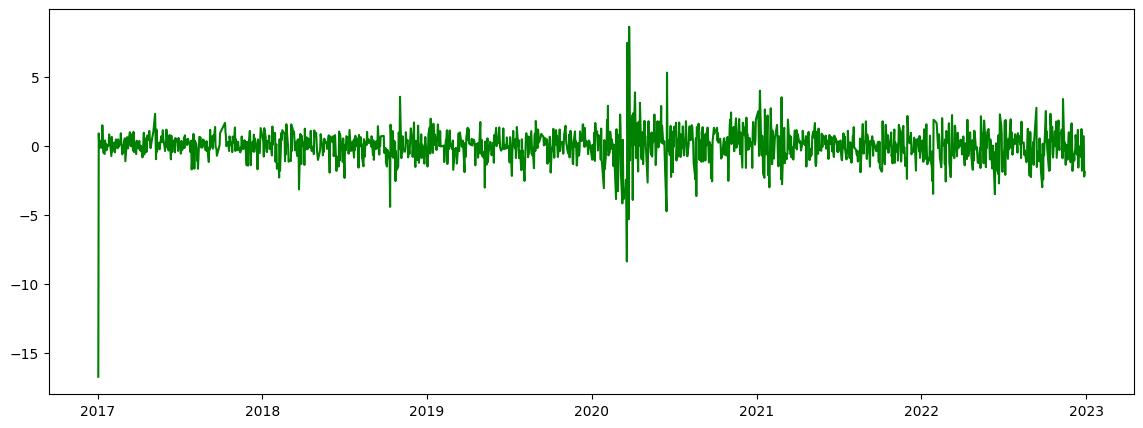

In [ ]:
# plotting
plt.figure(figsize=(14, 5))

# plot original 'returns' prices
plt.plot(dates, original_returns, color='green', label='Original Returns')

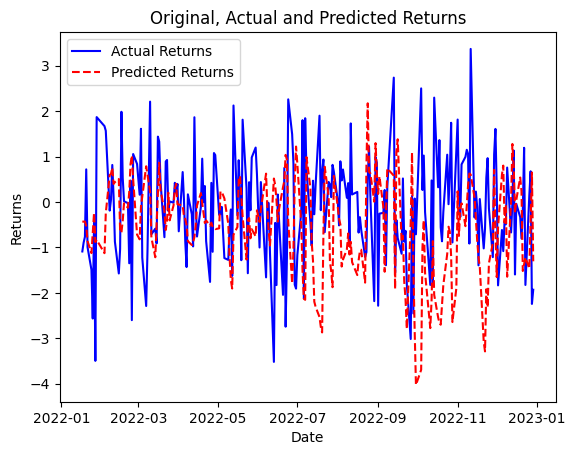

In [ ]:
# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Returns')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Original, Actual and Predicted Returns')
plt.legend()
plt.show()

In [ ]:
len(y_pred)

236

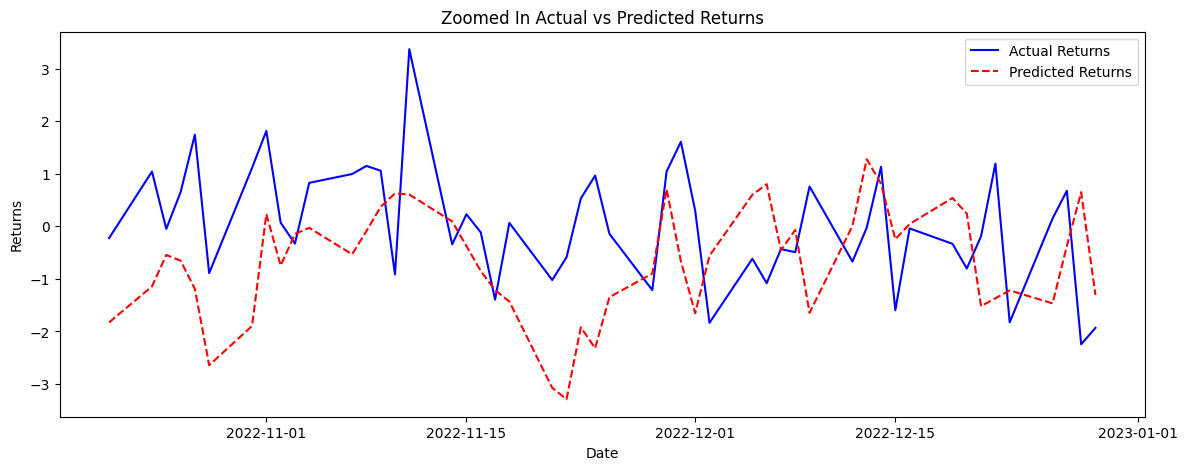

In [ ]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Returns')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Returns')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Zoomed In Actual vs Predicted Returns')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print("RMSE: %f" % (rmse))
# RMSE: 0.160966 ..?gg
# RMSE: 0.139228 옹예

RMSE: 1.679558


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(testY_original, y_pred)
print("MAE: %f" % (mae))

MAE: 1.121826


In [ ]:
model.save('ks_lstm_last.h5')

#추가적으로 할일 (0822)
- 상관관계가 높은 변수 제외  
다중공선성 문제를 방지 -> 유사도 높은 것들은 하나의 값만 넣기
- 종속변수 정규화(xgboost) -> 파라미터/ standard는 오히려 성능 x
- 앙상블 (참고: https://knowallworld.tistory.com/399)
  - ligthgbm이랑 해보자


In [ ]:
# 모델 불러오기
xgb_model = joblib.load(open(filename, 'rb'))

In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('ks_lstm.h5')

In [ ]:
raw_train.corr()

close      open      high       low       rsi  MACD_12_26  \
close            1.000000  0.998375  0.999124  0.999388  0.093970    0.207617   
open             0.998375  1.000000  0.999412  0.999109  0.077492    0.202925   
high             0.999124  0.999412  1.000000  0.998981  0.079538    0.202265   
low              0.999388  0.999109  0.998981  1.000000  0.091370    0.208615   
rsi              0.093970  0.077492  0.079538  0.091370  1.000000    0.792040   
MACD_12_26       0.207617  0.202925  0.202265  0.208615  0.792040    1.000000   
MACD_sign_12_26  0.222400  0.220860  0.220553  0.223218  0.654775    0.957104   
hband            0.961964  0.964015  0.965907  0.960180 -0.083501    0.038903   
mavg             0.976027  0.977958  0.978073  0.976111 -0.066910    0.069170   
lband            0.969215  0.970984  0.969325  0.971162 -0.048918    0.097907   
CSI              0.421084  0.422053  0.414838  0.429298  0.004418    0.008078   
target           0.034906 -0.006074  0.008983  0.017759  0.319375    0.072864   

                 MACD_sign_12_26     hband      mavg     lband       CSI  \
close                   0.222400  0.961964  0.976027  0.969215  0.421084   
open                    0.220860  0.964015  0.977958  0.970984  0.422053   
high                    0.220553  0.965907  0.978073  0.969325  0.414838   
low                     0.223218  0.960180  0.976111  0.971162  0.429298   
rsi                     0.654775 -0.083501 -0.066910 -0.048918  0.004418   
MACD_12_26              0.957104  0.038903  0.069170  0.097907  0.008078   
MACD_sign_12_26         1.000000  0.093409  0.123129  0.150169  0.038487   
hband                   0.093409  1.000000  0.989291  0.957467  0.361197   
mavg                    0.123129  0.989291  1.000000  0.989328  0.427363   
lband                   0.150169  0.957467  0.989328  1.000000  0.484285   
CSI                     0.038487  0.361197  0.427363  0.484285  1.000000   
target                  0.015550 -0.039216 -0.041348 -0.042593 -0.025145   

                   target  
close            0.034906  
open            -0.006074  
high             0.008983  
low              0.017759  
rsi              0.319375  
MACD_12_26       0.072864  
MACD_sign_12_26  0.015550  
hband           -0.039216  
mavg            -0.041348  
lband           -0.042593  
CSI             -0.025145  
target           1.000000

In [ ]:
raw_train.drop('hband', axis=1, inplace=True)
raw_train.drop('lband', axis=1, inplace=True)
raw_train.drop('MACD_sign_12_26', axis=1, inplace=True)

In [ ]:
raw_train

close     open     high      low        rsi  MACD_12_26  \
date                                                                    
2017-01-02  2026.16  2022.23  2031.79  2015.68  51.846817    1.534583   
2017-01-03  2043.97  2034.31  2044.07  2028.47  51.846817    1.534583   
2017-01-04  2045.64  2046.29  2046.29  2040.61  51.846817    1.534583   
2017-01-05  2041.95  2045.52  2046.50  2039.49  51.846817    1.534583   
2017-01-06  2049.12  2048.11  2051.84  2045.66  51.846817    1.534583   
...             ...      ...      ...      ...        ...         ...   
2022-12-23  2313.69  2325.86  2333.08  2311.90  38.363622  -15.931807   
2022-12-26  2317.14  2312.54  2321.92  2304.20  39.169097  -18.026966   
2022-12-27  2332.79  2327.52  2335.99  2321.48  42.819515  -18.214604   
2022-12-28  2280.45  2296.45  2296.45  2276.90  35.209547  -22.329310   
2022-12-29  2236.40  2265.73  2272.67  2236.38  30.324860  -28.812578   

                   mavg   CSI     target  
date                                      
2017-01-02  2436.844485  93.3 -16.745712  
2017-01-03  2436.844485  93.3   0.879003  
2017-01-04  2436.844485  93.3   0.081704  
2017-01-05  2436.844485  93.3  -0.180384  
2017-01-06  2436.844485  93.3   0.351135  
...                 ...   ...        ...  
2022-12-23  2386.713000  90.2  -1.826259  
2022-12-26  2382.156500  90.2   0.149112  
2022-12-27  2377.126500  90.2   0.675402  
2022-12-28  2367.522500  90.2  -2.243665  
2022-12-29  2355.350500  90.2  -1.931636  

[1475 rows x 9 columns]

In [ ]:
df = raw_train.loc[:,'close']

In [ ]:
!pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48444 sha256=0fa935b243dad240fdd7513861c6bcf0ca497e25777363ed6c053710950554f4
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


In [ ]:
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

In [ ]:
state_means, _ = kf.filter(df)

In [ ]:
df_smoothed = df.to_frame('close')
df_smoothed['Kalman Filter'] = state_means

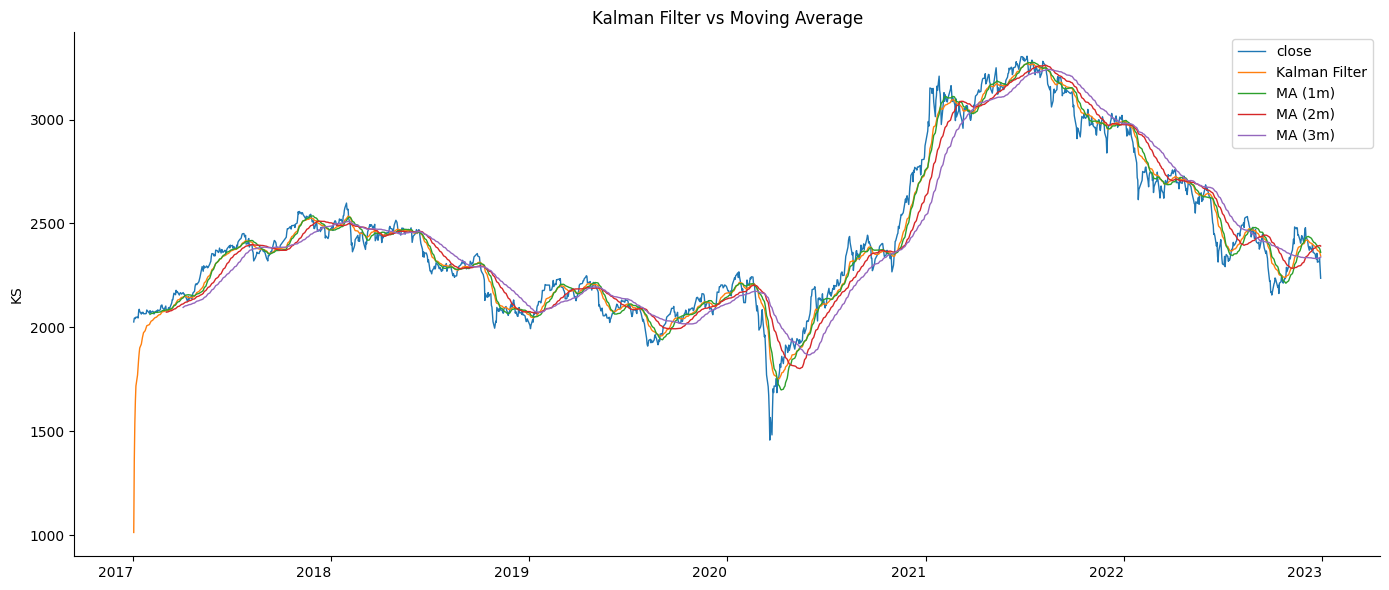

In [ ]:
for months in [1,2,3]:
    df_smoothed[f'MA ({months}m)'] = df.rolling(window=months*21).mean()

ax = df_smoothed.plot(title='Kalman Filter vs Moving Average', figsize=(14,6), lw=1, rot=0)
ax.set_xlabel('')
ax.set_ylabel('KS')
plt.tight_layout()
import seaborn as sns
sns.despine();

In [ ]:
raw_train['kalman'] = df_smoothed['Kalman Filter']

In [ ]:
raw_train.corr()

close      open      high       low       rsi  MACD_12_26  \
close       1.000000  0.998375  0.999124  0.999388  0.093970    0.207617   
open        0.998375  1.000000  0.999412  0.999109  0.077492    0.202925   
high        0.999124  0.999412  1.000000  0.998981  0.079538    0.202265   
low         0.999388  0.999109  0.998981  1.000000  0.091370    0.208615   
rsi         0.093970  0.077492  0.079538  0.091370  1.000000    0.792040   
MACD_12_26  0.207617  0.202925  0.202265  0.208615  0.792040    1.000000   
mavg        0.976027  0.977958  0.978073  0.976111 -0.066910    0.069170   
CSI         0.421084  0.422053  0.414838  0.429298  0.004418    0.008078   
target      0.034906 -0.006074  0.008983  0.017759  0.319375    0.072864   
kalman      0.981646  0.983418  0.983729  0.981539 -0.051846    0.079665   

                mavg       CSI    target    kalman  
close       0.976027  0.421084  0.034906  0.981646  
open        0.977958  0.422053 -0.006074  0.983418  
high        0.978073  0.414838  0.008983  0.983729  
low         0.976111  0.429298  0.017759  0.981539  
rsi        -0.066910  0.004418  0.319375 -0.051846  
MACD_12_26  0.069170  0.008078  0.072864  0.079665  
mavg        1.000000  0.427363 -0.041348  0.977631  
CSI         0.427363  1.000000 -0.025145  0.432337  
target     -0.041348 -0.025145  1.000000 -0.002980  
kalman      0.977631  0.432337 -0.002980  1.000000

In [ ]:
raw_train.columns

Index(['date', 'close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'mavg',
       'CSI', 'kalman', 'target'],
      dtype='object')

In [ ]:
raw_train = raw_train[['close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'mavg', 'CSI', 'kalman',
       'target']]

In [ ]:
raw_train = raw_train.astype('float')

In [ ]:
raw_train.to_csv("adj_raw_train.csv")

In [ ]:
raw_train = raw_train.reset_index()

##  Prophet
- https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
import pandas as pd
raw_train = pd.read_csv("/content/drive/MyDrive/adj_raw_train.csv")

In [ ]:
df = pd.DataFrame()

In [ ]:
df

ds          y
0     2017-01-02 -16.745712
1     2017-01-03   0.879003
2     2017-01-04   0.081704
3     2017-01-05  -0.180384
4     2017-01-06   0.351135
...          ...        ...
1470  2022-12-23  -1.826259
1471  2022-12-26   0.149112
1472  2022-12-27   0.675402
1473  2022-12-28  -2.243665
1474  2022-12-29  -1.931636

[1475 rows x 2 columns]

In [ ]:
df['DS'] = raw_train['date']

In [ ]:
df['Y'] = raw_train['target']

In [ ]:
df.columns = ['ds','y']

In [ ]:
from prophet import Prophet
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vz90ckv/_sv98un4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vz90ckv/52rn6ss8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16432', 'data', 'file=/tmp/tmp3vz90ckv/_sv98un4.json', 'init=/tmp/tmp3vz90ckv/52rn6ss8.json', 'output', 'file=/tmp/tmp3vz90ckv/prophet_modeljtrz23tp/prophet_model-20230823005411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:54:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:54:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
1835 2023-12-25
1836 2023-12-26
1837 2023-12-27
1838 2023-12-28
1839 2023-12-29

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
1835 2023-12-25 -0.489701   -1.994737    0.983366
1836 2023-12-26 -0.191899   -1.635290    1.272980
1837 2023-12-27 -0.386970   -1.988977    1.089107
1838 2023-12-28 -0.434483   -1.965281    1.063594
1839 2023-12-29 -0.315242   -1.734297    1.215756

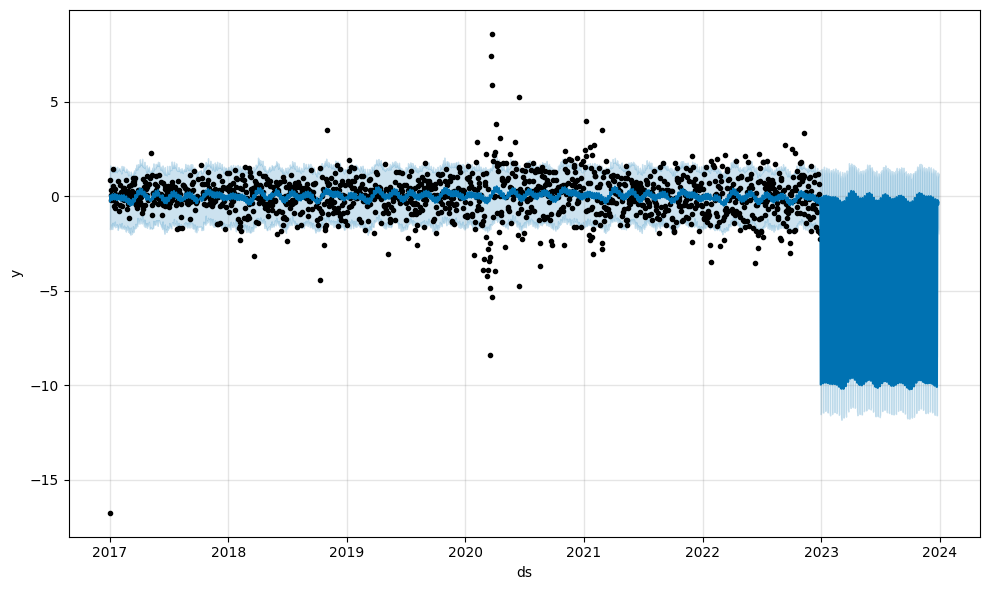

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

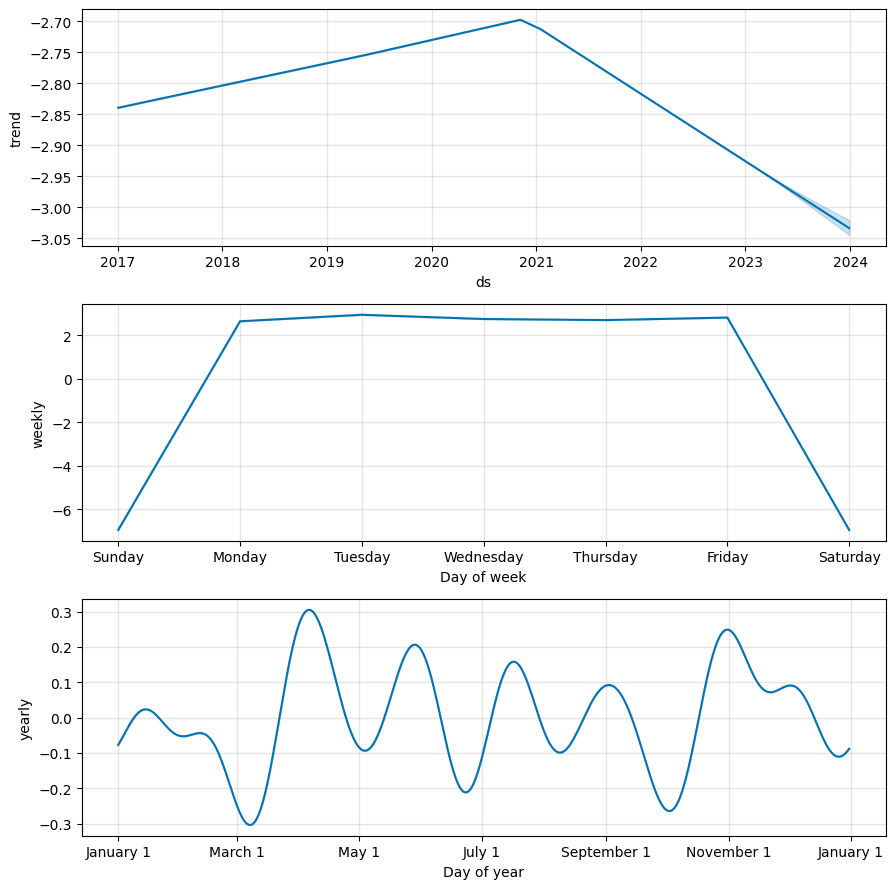

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
# plot_components_plotly(m, forecast)

- 수익률로만 따지니까 이상하게 나와서 정규화 다시 해봄..

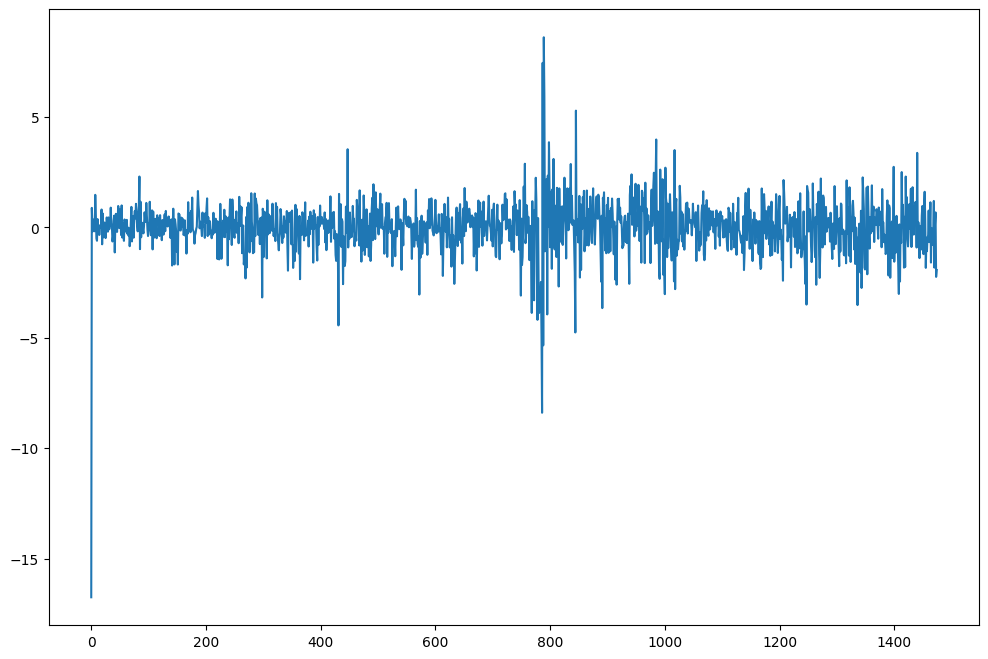

In [ ]:
data = raw_train['target'].values
plt.figure(figsize=(12, 8))
plt.plot(data)
plt.show()

In [ ]:
# import plotly.graph_objects as go
# fig = go.Figure()
# fig.update_traces(x=data, selector=dict(type='ohlc'))
# fig.update_traces(value=data, selector=dict(type='indicator'))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = np.array(data).reshape(-1,1)    # 표준화를 하기 위해 사이즈를 (-1,1)로 조정

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
scaled

array([[0.        ],
       [0.69533851],
       [0.6638831 ],
       ...,
       [0.68730594],
       [0.57214155],
       [0.58445186]])

In [ ]:
df.drop('y', axis=1, inplace=True)

In [ ]:
df['y'] = scaled

In [ ]:
df

ds         y
0     2017-01-02  0.000000
1     2017-01-03  0.695339
2     2017-01-04  0.663883
3     2017-01-05  0.653543
4     2017-01-06  0.674513
...          ...       ...
1470  2022-12-23  0.588609
1471  2022-12-26  0.666543
1472  2022-12-27  0.687306
1473  2022-12-28  0.572142
1474  2022-12-29  0.584452

[1475 rows x 2 columns]

In [ ]:
from prophet import Prophet

train_df = df.head(-246)

m = Prophet(seasonality_mode='additive')
m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_qo6h16/bfq6c04l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_qo6h16/6p8d56f3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27601', 'data', 'file=/tmp/tmp3_qo6h16/bfq6c04l.json', 'init=/tmp/tmp3_qo6h16/6p8d56f3.json', 'output', 'file=/tmp/tmp3_qo6h16/prophet_models6ct3srx/prophet_model-20230823014953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


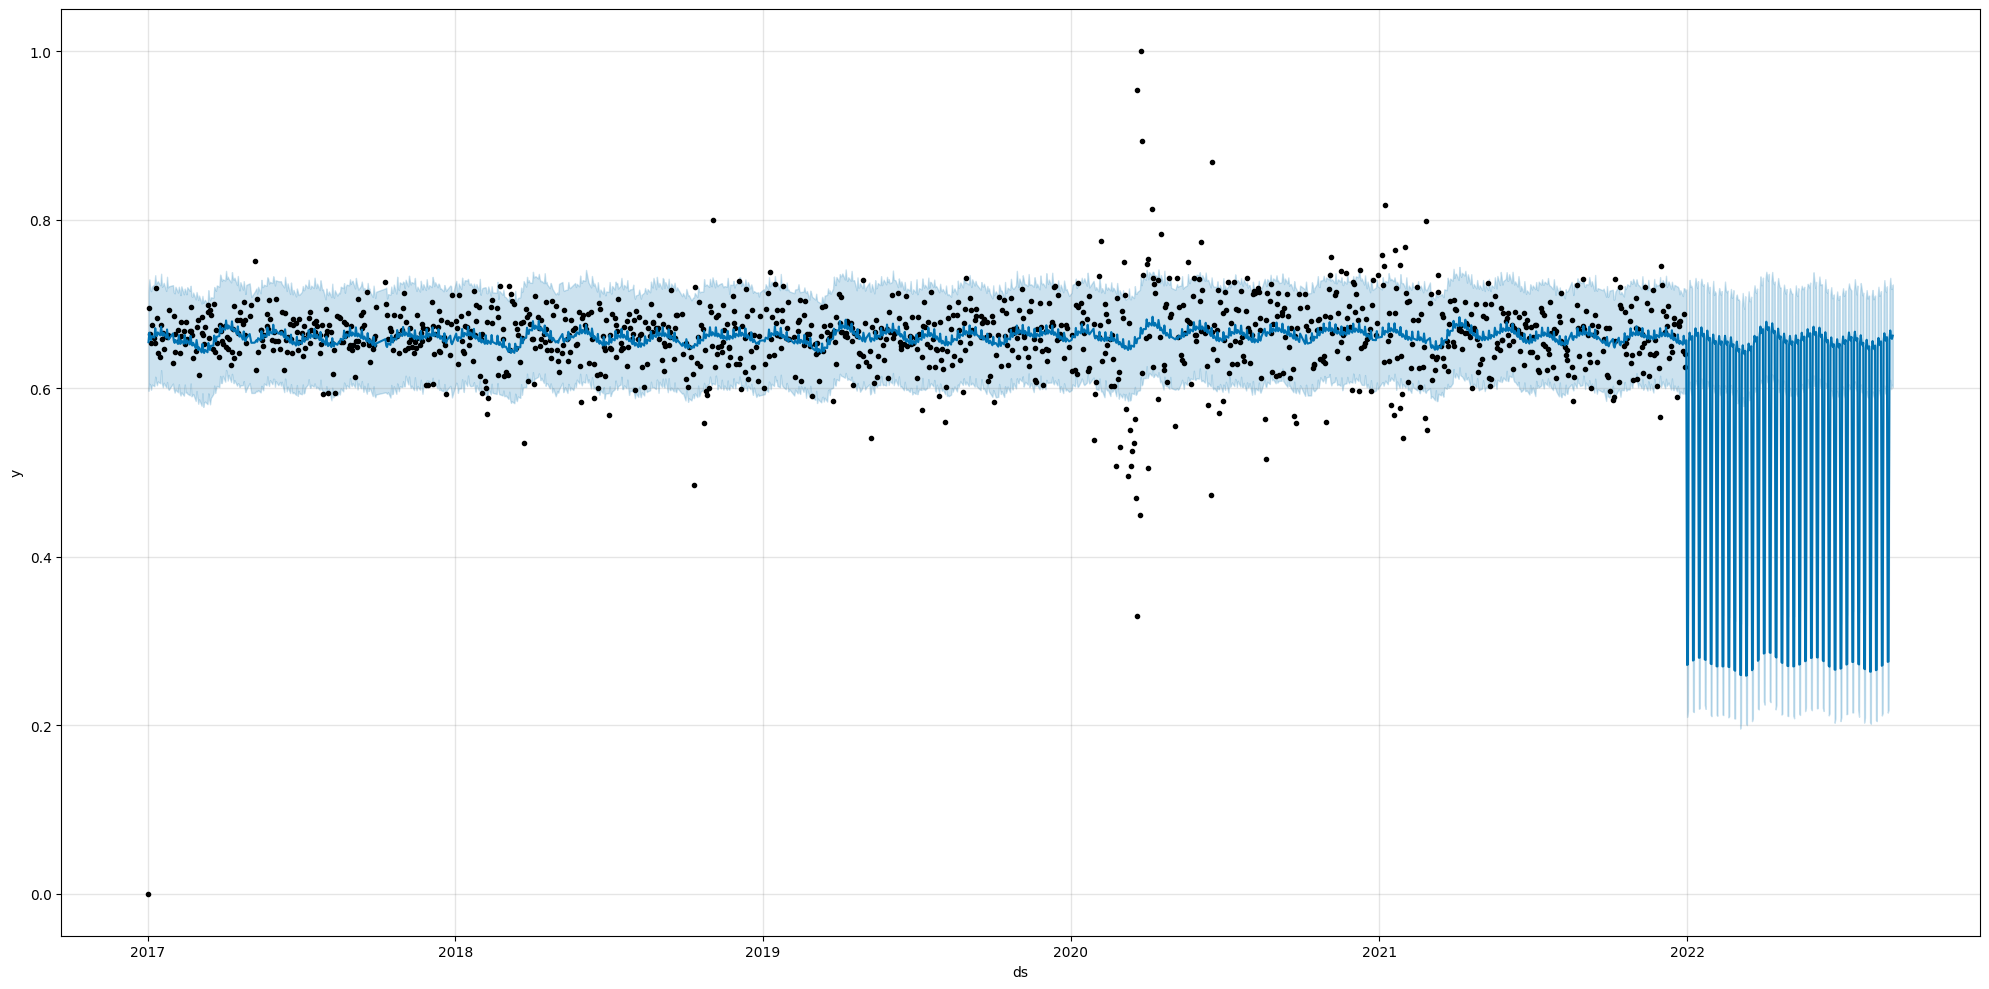

In [ ]:
fig1 = m.plot(forecast, figsize=(20,10))

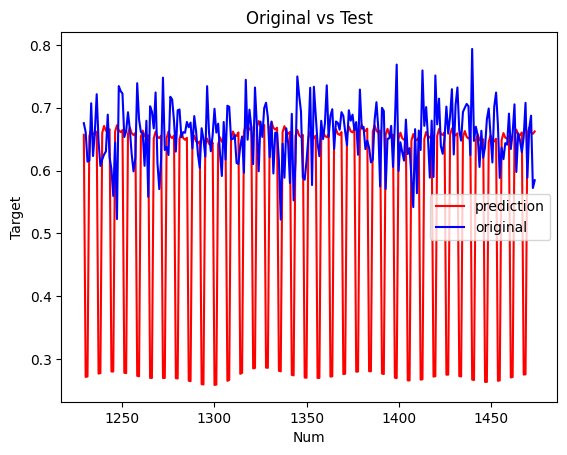

In [ ]:
plt.plot(forecast.iloc[-246:,:].yhat,'r', label='prediction')
plt.plot(test_df.y,'b', label='original')
plt.xlabel('Num')
plt.ylabel('Target')
plt.legend()
plt.title('Original vs Test')
plt.show()

달라지는게 없었다...

In [ ]:
future_df = df.copy()
future_df = m.make_future_dataframe(periods=246)
future_df.rename(columns={'date':'ds'},inplace=True)
forecast = m.predict(future_df)

In [ ]:
from prophet import Prophet


train_df = df.head(-246)

m = Prophet(seasonality_mode='additive')
m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vz90ckv/a7dpxfu_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vz90ckv/7m7lkpxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75232', 'data', 'file=/tmp/tmp3vz90ckv/a7dpxfu_.json', 'init=/tmp/tmp3vz90ckv/7m7lkpxp.json', 'output', 'file=/tmp/tmp3vz90ckv/prophet_modelc9fh9iev/prophet_model-20230823012323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_df = df.copy()
future_df = m.make_future_dataframe(periods=246)
future_df.rename(columns={'date':'ds'},inplace=True)
forecast = m.predict(future_df)

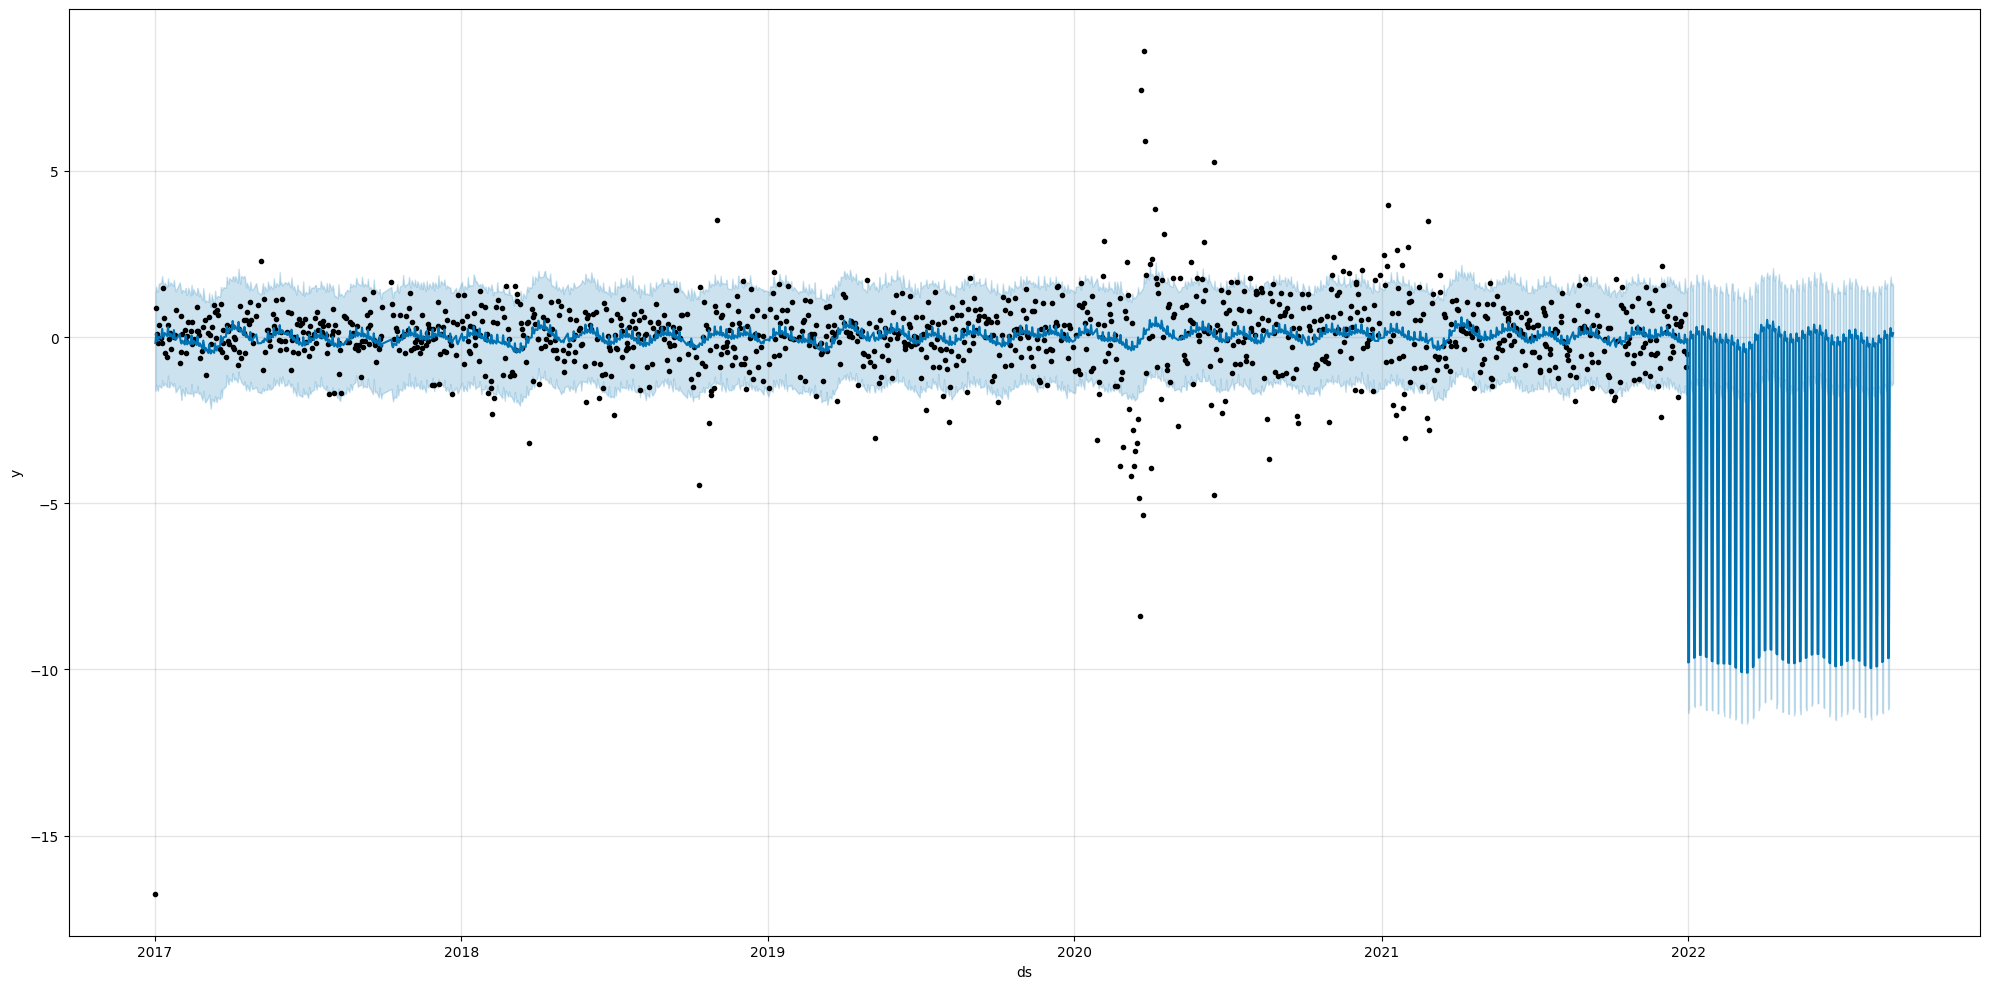

In [ ]:
fig1 = m.plot(forecast, figsize=(20,10))

In [ ]:
test_df = df.tail(246)

In [ ]:
test_df.y

1229    0.373449
1230    0.015726
1231   -1.179899
1232   -1.132036
1233    1.176499
          ...   
1470   -1.826259
1471    0.149112
1472    0.675402
1473   -2.243665
1474   -1.931636
Name: y, Length: 246, dtype: float64

In [ ]:
forecast.iloc[-246:,:].yhat

1229   -0.062641
1230   -9.793304
1231   -9.776141
1232   -0.114165
1233    0.171887
          ...   
1470   -0.000394
1471    0.271997
1472    0.070489
1473    0.018359
1474    0.115933
Name: yhat, Length: 246, dtype: float64

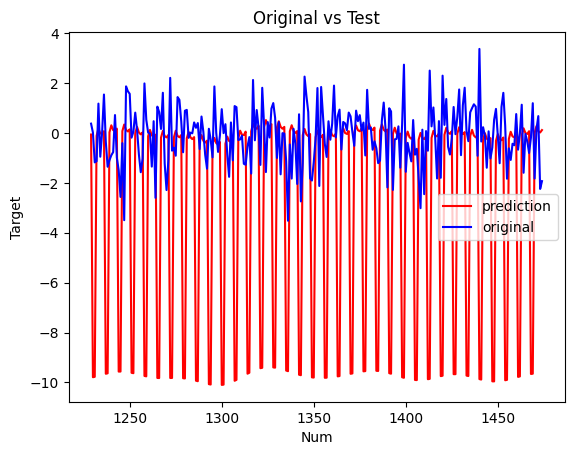

In [ ]:
plt.plot(forecast.iloc[-246:,:].yhat,'r', label='prediction')
plt.plot(test_df.y,'b', label='original')
plt.xlabel('Num')
plt.ylabel('Target')
plt.legend()
plt.title('Original vs Test')
plt.show()


In [ ]:
# prophet 모듈 세팅
from prophet import Prophet

# Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
model = Prophet(daily_seasonality=True)

# 데이터 학습 시작 -> 기계학습
model.fit(df[['ds', 'y']].iloc[:-10])

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_qo6h16/c6s789qo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_qo6h16/qow_sqz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36170', 'data', 'file=/tmp/tmp3_qo6h16/c6s789qo.json', 'init=/tmp/tmp3_qo6h16/qow_sqz2.json', 'output', 'file=/tmp/tmp3_qo6h16/prophet_modelwfgdpt1z/prophet_model-20230823014014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 14일치 예측값
future = model.make_future_dataframe(periods=10)

# 주가 예측
forecast = model.predict(future)

In [ ]:
# 필요한 컬럼만 보기
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11)

ds      yhat  yhat_lower  yhat_upper
1464 2022-12-15 -0.186974   -1.675542    1.417803
1465 2022-12-16 -0.075339   -1.423769    1.458976
1466 2022-12-17 -2.375232   -3.851345   -0.811536
1467 2022-12-18 -2.383938   -3.889134   -0.824188
1468 2022-12-19 -0.279084   -1.772650    1.327754
1469 2022-12-20  0.015028   -1.443925    1.490446
1470 2022-12-21 -0.179944   -1.691582    1.243374
1471 2022-12-22 -0.240671   -1.750239    1.243764
1472 2022-12-23 -0.123220   -1.735371    1.449186
1473 2022-12-24 -2.416334   -3.925292   -0.818932
1474 2022-12-25 -2.417465   -3.967492   -0.901257

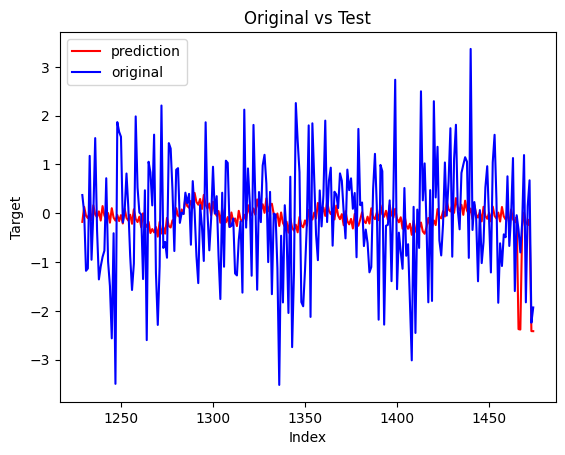

In [ ]:
import matplotlib.pyplot as plt
plt.plot(forecast.iloc[-246:,:].yhat,'r', label='prediction')
plt.plot(df.iloc[-246:,:].y,'b', label='original')
plt.xlabel('Index')
plt.ylabel('Target')
plt.legend()
plt.title('Original vs Test')
plt.show()

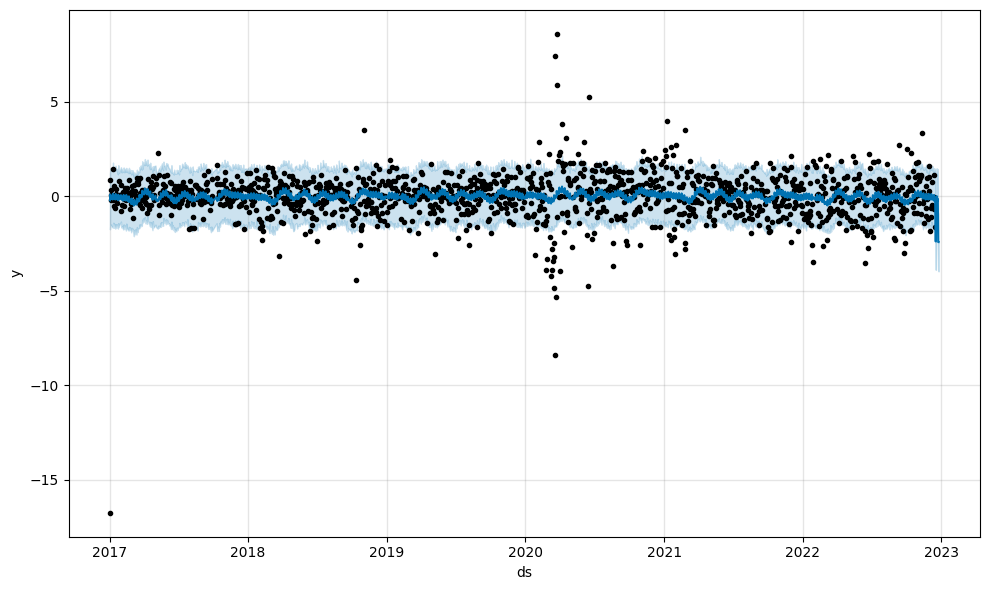

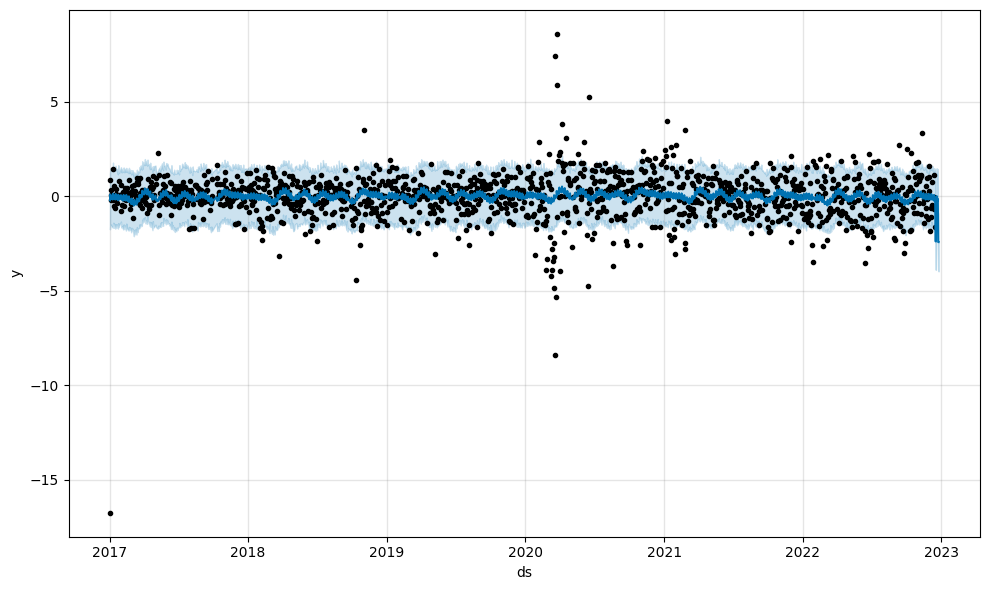

In [ ]:
# 모델이 제공하는 시각화
model.plot(forecast)

- prophet 모델 gridsearch